# Problem 2 - Generative Adversarial Networks (GAN)

* **Learning Objective**: In this problem, you will implement a Generative 
Adversarial Network with the network structure proposed in [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/pdf/1511.06434.pdf). You will also learn a visualization technique: activation maximization.
* **Provided code**: The code for constructing the two parts of the GAN, the discriminator and the generator, is done for you, along with the skeleton code for the training.
* **TODOs**: You will need to figure out how to define the training loop, compute the loss, and update the parameters to complete the training and visualization. In addition, to test your understanding, you will answer some non-coding written questions. Please see details below.

**Note**: 


* If you use the Colab, for faster training of the models in this assignment, you can enable GPU support in the Colab. Navigate to "Runtime" --> "Change Runtime Type" and set the "Hardware Accelerator" to "GPU". **However, Colab has the GPU limit, so be discretional with your GPU usage.**
* If you run into CUDA errors in the Colab, check your code carefully. After fixing your code, if the CUDA error shows up at a previously correct line, restart the Colab. However, this is not a fix to all your CUDA issues. Please check your implementation carefully.



In [ ]:
# Import required libraries
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt
import math
from torchvision.utils import make_grid
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# **Introduction: The forger versus the police**
**Please read the information below even if you are familiar with GANs. There are some terms below that will be used in the coding part.**

Generative models try to model the distribution of the data in an explicit way, in the sense that we can easily sample new data points from this model. This is in contrast to discriminative models that try to infer the output from the input. In class and in the previous problem, we have seen one classic deep generative model, the Variational Autoencoder (VAE). Here, we will learn another generative model that has risen to prominence in recent years, the Generative Adversarial Network (GAN).

As the math of Generative Adversarial Networks are somewhat tedious, a story is often told of a forger and a police officer to illustrate the idea.



> Imagine a forger that makes fake bills, and a police officer that tries to find these forgeries. If the forger were a VAE, his goal would be to take some real bills, and try to replicate the real bills as precisely as possible. With GANs, the forger has a different idea: rather than trying to replicate the real bills, it suffices to make fake bills such that people think they are real.

> Now let's start. In the beginning, the police knows nothing about how to distinguish between real and fake bills. The forger knows nothing either and only produces white paper.

> In the first round, the police gets the fake bill and learns that the forgeries are white while the real bills are green. The forger then finds out that white papers can no longer fool the police and starts to produce green papers.

> In the second round, the police learns that real bills have denominations printed on them while the forgeries do not. The forger then finds out that plain papers can no longer fool the police and starts to print numbers on them.

> In the third round, the police learns that real bills have watermarks on them while the forgeries do not. The forger then has to reproduce the watermarks on his fake bills.

> ...

> Finally, the police is able to spot the tiniest difference between real and fake bills and the forger has to make perfect replicas of real bills to fool the police.

Now in a GAN, the forger becomes the generator and the police becomes the discriminator. The discriminator is a binary classifier with the two classes being "taken from the real data" ("real") and "generated by the generator" ("fake"). Its objective is to minimize the classification loss. The generator's objective is to generate samples so that the discriminator misclassifies them as real.

Here we have some complications: the goal is not to find one perfect fake sample. Such a sample will not actually fool the discriminator: if the forger makes hundreds of the exact same fake bill, they will all have the same serial number and the police will soon find out that they are fake. Instead, we want the generator to be able to generate a variety of fake samples such that when presented as a distribution alongside the distribution of real samples, these two are indistinguishable by the discriminator.

So how do we generate different samples with a deterministic generator? We provide it with random numbers as input.


Typically, for the discriminator we use *binary cross entropy loss* with label 1 being real and 0 being fake. For the generator, the input is a random vector drawn from a standard normal distribution. Denote the generator by $G_\phi(z)$, discriminator by $D_\theta (x)$, the distribution of the real samples by $p(x)$, and the input distribution to the generator by $q(z)$. Recall that the binary cross entropy loss with classifier output $y$ and label $\hat{y}$ is 

$$L(y, \hat{y}) = -\hat{y} \log y - (1 - \hat{y}) \log (1 - y)$$

For the discriminator, the objective is 
$$\min_{\theta} \mathrm{E}_{x \sim p(x)}[L(D_{\theta}(x), 1)] + \mathrm{E}_{z \sim q(z)}[L(D_{\theta}(G_{\phi}(z)), 0)]$$

For the generator, the objective is 
$$\max_{\phi} \mathrm{E}_{z \sim q(z)}[L(D_{\theta}(G_{\phi}(z)), 0)]$$

The generator's objective corresponds to maximizing the classification loss of the discriminator on the generated samples. Alternatively, we can **minimize** the *classification loss* of the discriminator on the generated samples **when labelled as real:**
$$\min_{\phi} \mathrm{E}_{z \sim q(z)}[L(D_{\theta}(G_{\phi}(z)), 1)]$$

And this is what we will use in our implementation. The strength of the two networks should be balanced, so we train the two networks alternatingly, updating the parameters in both networks once in each iteration.

# **Problem 2-1: Implementing the GAN (20 pts)**

Correctly filling out `__init__`: 7 pts

Correctly filling out training loop: 13 pts

We first load the data (CIFAR-10) and define some convenient functions. You can run the cell below to download the dataset to `./data`.

In [ ]:
 !wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -P data
 !tar -xzvf data/cifar-10-python.tar.gz --directory data
 !rm data/cifar-10-python.tar.gz

--2023-04-03 03:00:03--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘data/cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  13.1MB/s    in 14s     

2023-04-03 03:00:17 (11.8 MB/s) - ‘data/cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [ ]:
def unpickle(file):
    import sys
    if sys.version_info.major == 2:
        import cPickle
        with open(file, 'rb') as fo:
            dict = cPickle.load(fo)
        return dict['data'], dict['labels']
    else:
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict[b'data'], dict[b'labels']
def load_train_data():
    X = []
    for i in range(5):
        X_, _ = unpickle('data/cifar-10-batches-py/data_batch_%d' % (i + 1))
        X.append(X_)
    X = np.concatenate(X)
    X = X.reshape((X.shape[0], 3, 32, 32))
    return X

def load_test_data():
    X_, _ = unpickle('data/cifar-10-batches-py/test_batch')
    X = X_.reshape((X_.shape[0], 3, 32, 32))
    return X

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)

# Load cifar-10 data
train_samples = load_train_data() / 255.0
test_samples= load_test_data() / 255.0

To save you some mundane work, we have defined a discriminator and a generator for you. Look at the code to see what layers are there.

##**For this part, you need to complete code blocks marked with "Prob 2-1":**

* **Build the Discriminator and Generator, define the loss objectives** 
* **Define the optimizers** 
* **Build the training loop and compute the losses**: As per [How to Train a GAN? Tips and tricks to make GANs work](https://urldefense.com/v3/__https://github.com/soumith/ganhacks__;!!LIr3w8kk_Xxm!_OyEq6RR8H2WeaK3_oOAGVDF3QgpTm6kRTMtpMyD8QNo1-3RJzf5a8HAGSXVdQ$), we put real samples and fake samples in different batches when training the discriminator.

Note: use the advice on that page with caution if you are using GANs for your team project. It is already 4 years old, which is a really long time in deep learning research. It does not reflect the latest results.


In [ ]:
class Generator(nn.Module):
    def __init__(self, starting_shape):
        super(Generator, self).__init__()
        self.fc = nn.Linear(starting_shape, 4 * 4 * 128)
        self.upsample_and_generate = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=4, stride=2, padding=1, bias=True),
            nn.Sigmoid()
        )
    def forward(self, input):
        transformed_random_noise = self.fc(input)
        reshaped_to_image = transformed_random_noise.reshape((-1, 128, 4, 4))
        generated_image = self.upsample_and_generate(reshaped_to_image)
        return generated_image

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1, bias=True),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
        )
        self.fc = nn.Linear(4 * 4 * 128, 1)
    def forward(self, input):
        downsampled_image = self.downsample(input)
        reshaped_for_fc = downsampled_image.reshape((-1, 4 * 4 * 128))
        classification_probs = self.fc(reshaped_for_fc)
        return classification_probs

In [ ]:
# Use this to put tensors on GPU/CPU automatically when defining tensors
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

class DCGAN(nn.Module):
    def __init__(self):
        super(DCGAN, self).__init__()
        self.num_epoch = 25
        self.batch_size = 128
        self.log_step = 100 
        self.visualize_step = 2 
        self.code_size = 64  # size of latent vector (size of generator input)
        self.learning_rate = 2e-4
        self.vis_learning_rate = 1e-2
        
        # IID N(0, 1) Sample
        self.tracked_noise = torch.randn([64, self.code_size], device=device)        
        
        self._actmax_label = torch.ones([64, 1], device=device)
        
        ################################################################################
        # Prob 2-1: Define the generator and discriminator, and loss functions  #
        # Also, apply the custom weight initialization (see link:                      #
        # https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)            #
        ################################################################################
        # To-Do: Initialize generator and discriminator
        # use variable name "self._generator" and "self._discriminator", respectively
        # (also move them to torch device for accelerating the training later)
        self._generator = Generator(self.code_size).to(device)
        self._discriminator = Discriminator().to(device)

        # To-Do: Apply weight initialization (first implement the weight initialization 
        # function below by following the given link)
        self._generator.apply(self.weights_init)
        self._discriminator.apply(self.weights_init)
        ################################################################################
        # Prob 2-1: Define the generator and discriminators' optimizers                #
        # HINT: Use Adam, and the provided momentum values (betas)                     #
        ################################################################################
        betas = (0.5, 0.999)
        # To-Do: Initialize the generator's and discriminator's optimizers 
        self.optimizerD = torch.optim.Adam(self._discriminator.parameters(), lr=self.learning_rate, betas=betas)
        self.optimizerG = torch.optim.Adam(self._generator.parameters(), lr=self.learning_rate, betas=betas)



    # To-Do: Define weight initialization function
    # see link: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
    def weights_init(self, net):
      classname = net.__class__.__name__
      if classname.find('Conv') != -1:
          nn.init.normal_(net.weight.data, 0.0, 0.02)
      elif classname.find('BatchNorm') != -1:
          nn.init.normal_(net.weight.data, 1.0, 0.02)
          nn.init.constant_(net.bias.data, 0)


    # To-Do: Define a general classification loss function (sigmoid followed by binary cross entropy loss)
    def _classification_loss(self):
      criterion = nn.BCEWithLogitsLoss()
      return criterion


        ################################################################################
        #                               END OF YOUR CODE                               #
        ################################################################################

    # Training function
    def train(self, train_samples):
        num_train = train_samples.shape[0]
        step = 0
        
        # smooth the loss curve so that it does not fluctuate too much
        smooth_factor = 0.95
        plot_dis_s = 0
        plot_gen_s = 0
        plot_ws = 0
        
        dis_losses = []
        gen_losses = []
        max_steps = int(self.num_epoch * (num_train // self.batch_size))
        fake_label = torch.zeros([self.batch_size, 1], device=device)
        real_label = torch.ones([self.batch_size, 1], device=device)
        self._generator.train()
        self._discriminator.train()
        print('Start training ...')
        for epoch in range(self.num_epoch):
            np.random.shuffle(train_samples)
            for i in range(num_train // self.batch_size):
                step += 1

                batch_samples = train_samples[i * self.batch_size : (i + 1) * self.batch_size]
                batch_samples = torch.Tensor(batch_samples).to(device)

                ################################################################################
                # Prob 2-1: Train the discriminator on all real images first            #
                ################################################################################
                # To-Do: HINT: Remember to eliminate all discriminator gradients first! (.zero_grad())
                self._discriminator.zero_grad()
                self.optimizerD.zero_grad()
                # To-Do: feed real samples to the discriminator
                data = batch_samples
                label = torch.full((self.batch_size,), 1, dtype=torch.float, device=device)
                output = self._discriminator(data).view(-1)


                # To-Do: calculate the discriminator loss for real samples
                # use the variable name "real_dis_loss"
                loss = self._classification_loss()
                real_dis_loss = loss(output, label)


                ################################################################################
                # Prob 2-1: Train the discriminator with an all fake batch                     #
                ################################################################################   
                # To-Do: sample noises from IID Normal(0, 1)^d on the torch device
                noise = torch.randn(self.batch_size, self.code_size, device=device)
                label_fake = torch.full((self.batch_size,), 0, dtype=torch.float, device=device)



                # To-Do: generate fake samples from the noise using the generator
                fake = self._generator(noise)


                # To-Do: feed fake samples to discriminator
                # Make sure to detach the fake samples from the gradient calculation 
                # when feeding to the discriminator, we don't want the discriminator to 
                # receive gradient info from the Generator
                output_fake = self._discriminator(fake.detach()).view(-1)



                # To-Do: calculate the discriminator loss for fake samples
                # use the variable name "fake_dis_loss"
                loss = self._classification_loss()
                fake_dis_loss = loss(output_fake, label_fake)


                # To-Do: calculate the total discriminator loss (real loss + fake loss)
                total_loss = real_dis_loss + fake_dis_loss
                
                # To-Do: calculate the gradients for the total discriminator loss
                total_loss.backward()

                # To-Do: update the discriminator weights
                self.optimizerD.step()
                
                
                ################################################################################
                # Prob 2-1: Train the generator                                                #
                ################################################################################                
                # To-Do: Remember to eliminate all generator gradients first! (.zero_grad())
                self._generator.zero_grad()
                self.optimizerG.zero_grad()

    
                # To-Do: sample noises from IID Normal(0, 1)^d on the torch device
                noise = torch.randn(self.batch_size, self.code_size, device=device)

                # To-Do: generate fake samples from the noise using the generator
                fake_1 = self._generator(noise)



                # To-Do: feed fake samples to the discriminator
                # No need to detach from gradient calculation here, we want the 
                # generator to receive gradient info from the discriminator 
                # so it can learn better.
                out = self._discriminator(fake_1).view(-1)

 

                # To-Do: calculate the generator loss 
                # hint: the goal of the generator is to make the discriminator 
                # consider the fake samples as real
                loss = self._classification_loss()
                gen_loss = loss(out, label)

                # To-Do: Calculate the generator loss gradients
                gen_loss.backward()

                # To-Do: Update the generator weights
                self.optimizerG.step()

                
                
                ################################################################################
                #                               END OF YOUR CODE                               #
                ################################################################################

                dis_loss = real_dis_loss + fake_dis_loss
                
                plot_dis_s = plot_dis_s * smooth_factor + dis_loss * (1 - smooth_factor)
                plot_gen_s = plot_gen_s * smooth_factor + gen_loss * (1 - smooth_factor)
                plot_ws = plot_ws * smooth_factor + (1 - smooth_factor)
                dis_losses.append(plot_dis_s / plot_ws)
                gen_losses.append(plot_gen_s / plot_ws)

                if step % self.log_step == 0:
                    print('Iteration {0}/{1}: dis loss = {2:.4f}, gen loss = {3:.4f}'.format(step, max_steps, dis_loss, gen_loss))

            if epoch % self.visualize_step == 0:
                fig = plt.figure(figsize = (8, 8))   
                ax1 = plt.subplot(111)
                ax1.imshow(make_grid(self._generator(self.tracked_noise.detach()).cpu().detach(), padding=1, normalize=True).numpy().transpose((1, 2, 0)))
                plt.show()

                dis_losses_cpu = [_.cpu().detach() for _ in dis_losses]
                plt.plot(dis_losses_cpu)
                plt.title('discriminator loss')
                plt.xlabel('iterations')
                plt.ylabel('loss')
                plt.show()
    
                gen_losses_cpu = [_.cpu().detach() for _ in gen_losses]
                plt.plot(gen_losses_cpu)
                plt.title('generator loss')
                plt.xlabel('iterations')
                plt.ylabel('loss')
                plt.show()
        print('... Done!')



    #########################################################
    # Prob 2-4: Find the reconstruction of a batch of samples
    # **skip this part when working on problem 2-1 and come back for problem 2-4 
    ####################################################################
    # Prob 2-4: To-Do: Define squared L2-distance function (or Mean-Squared-Error) 
    # as reconstruction loss
    ####################################################################
    def _reconstruction_loss(self):
      criterion = nn.MSELoss()
      return criterion


    def reconstruct(self, samples):
        recon_code = torch.zeros([samples.shape[0], self.code_size], device=device, requires_grad=True)
        samples = torch.tensor(samples, device=device, dtype=torch.float32)

        # Set the generator to evaluation mode, to make batchnorm stats stay fixed
        self._generator.eval()

        ################################################################################
        # Prob 2-4: complete the definition of the optimizer.                          #
        # **skip this part when working on problem 2-1 and come back for problem 2-4   #
        ################################################################################       
        # To-Do: define the optimizer
        # Hinit: Use self.vis_learning_rate as one of the parameters for Adam optimizer
        optimizer = torch.optim.Adam(params=self._generator.parameters(), lr=self.vis_learning_rate, betas=(0.5, 0.999))
 
        
        for i in range(500):
            ################################################################################
            # Prob 2-4: Fill in the training loop for reconstruciton                       #
            # **skip this part when working on problem 2-1 and come back for problem 2-4   #
            ################################################################################
            # To-Do: eliminate the gradients
            self._generator.zero_grad()
            optimizer.zero_grad()
            # To-Do: feed the reconstruction codes to the generator for generating reconstructed samples 
            # use the variable name "recon_samples"
            # recon_samples = [] # comment out this line when you are coding
            recon_samples = self._generator(recon_code)

            # To-Do: calculate reconstruction loss
            # use the variable name "recon_loss"
            # recon_loss = 0.0 # comment out this line when you are coding
            loss = self._reconstruction_loss()
            recon_loss = loss(recon_samples, samples)


            # To-Do: calculate the gradient of the reconstruction loss 
            recon_loss.backward()


            # To-Do: update the weights
            optimizer.step()


        
            ################################################################################
            #                               END OF YOUR CODE                               #
            ################################################################################
            
        return recon_loss, recon_samples.detach().cpu()
        

    # Perform activation maximization on a batch of different initial codes
    def actmax(self, actmax_code):
        self._generator.eval()
        self._discriminator.eval() 
        ################################################################################
        # Prob 2-4: just check this function. You do not need to code here             #
        # skip this part when working on problem 2-1 and come back for problem 2-4     #
        ################################################################################
        actmax_code = torch.tensor(actmax_code, device=device, dtype=torch.float32, requires_grad=True)
        actmax_optimizer = torch.optim.Adam([actmax_code], lr=self.vis_learning_rate) 
        for i in range(500):
            actmax_optimizer.zero_grad()
            actmax_sample = self._generator(actmax_code)
            actmax_dis = self._discriminator(actmax_sample)
            loss = self._classification_loss()
            actmax_loss = loss(actmax_dis, self._actmax_label)
            actmax_loss.backward()
            actmax_optimizer.step()
        return actmax_sample.detach().cpu()


Now let's do the training!

Don't panic if the loss curve goes wild. The two networks are competing for the loss curve to go different directions, so virtually anything can happen. If your code is correct, the generated samples should have a high variety.

**Do NOT change the number of epochs, learning rate, or batch size.** If you're using Google Colab, the batch size will not be an issue during training. 

In [ ]:
set_seed(42)

dcgan = DCGAN()
dcgan.train(train_samples)
torch.save(dcgan.state_dict(), "dcgan.pt")

# **Problem 2-2: The Batch Normalization dilemma (4 pts)**

Here are two questions related to the use of Batch Normalization in GANs. Q1 below will not be graded and the answer is provided. But you should attempt to solve it before looking at the answer. 

##**Q2 will be graded.**

---

***Q1:*** We made separate batches for real samples and fake samples when training the discriminator. Is this just an arbitrary design decision made by the inventor that later becomes the common practice, or is it critical to the correctness of the algorithm? **[0 pt]**

**Answer to Q1:** When we are training the generator, the input batch to the discriminator will always consist of only fake samples. If we separate real and fake batches when training the discriminator, then the fake samples are normalized in the same way when we are training the discriminator and when we are training the generator. If we mix real and fake samples in the same batch when training the discriminator, then the fake samples are not normalized in the same way when we train the two networks, which causes the generator to fail to learn the correct distribution.

***Q2:*** Look at the construction of the discriminator carefully. You will find that between dis_conv1 and dis_lrelu1 there is no batch normalization. This is not a mistake. What could go wrong if there were a batch normalization layer there? Why do you think that omitting this batch normalization layer solves the problem practically if not theoretically? **[3 pt]**

**Please provide your answer to Q2:**
Omitting batch normalization between dis_conv1 and dis_lrelu1 is intended because skipping this process will bring 2 benefits. Firstly, adding batch normalization layer between convolutional layer and activation layer is likely to amplify the possibility of vanishing gradient. Batch normalization is likely to make the situation worse because the model's input is likely to have a different distribution than the normalized input. Secondly, if we add a batch normalization layer at the initial stage of the discriminator, it is likely to make the discriminator too powerful at the initial stage, causing "Mode Collapse". This will lead GAN to be able to generate only part of sample types instead of variety types of sample. Hence, not adding this batch normalization layer will be helpful to avoid mode collapse, and avoid vanishing gradient as much as possible. In practice, using batch normalization at the initial stage of GAN is likely to make the model unstable, so it is omitted in the code.


---

Takeaway from this problem: **always excercise extreme caution when using batch normalization in your network!**

For further info (optional): you can read this paper to find out more about why Batch Normalization might be bad for your GANs: [On the Effects of Batch and Weight Normalization in Generative Adversarial Networks](https://urldefense.com/v3/__https://arxiv.org/abs/1704.03971__;!!LIr3w8kk_Xxm!_OyEq6RR8H2WeaK3_oOAGVDF3QgpTm6kRTMtpMyD8QNo1-3RJzf5a8EMoSoPDg$)

---


# **Problem 2-3: What about other normalization methods for GAN? (4 pts)**

[Spectral norm](https://arxiv.org/pdf/1802.05957.pdf) is a way of stabilizing the GAN training of discriminator. Please add the embedded spectral norm function in Pytorch to the Discriminator class below in order to test its effects. (see link: https://pytorch.org/docs/stable/generated/torch.nn.utils.spectral_norm.html)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        ################################################################################
        # Prob 2-3:                                                                    #
        # adding spectral norm to the discriminator                                    #
        ################################################################################
        self.downsample = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1, bias=True)),
            nn.LeakyReLU(),
            nn.utils.spectral_norm(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1, bias=True)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.utils.spectral_norm(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=True)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
        )
        ################################################################################
        # END OF YOUR CODE                                                             #
        ################################################################################
        self.fc = nn.Linear(4 * 4 * 128, 1)
    def forward(self, input):
        downsampled_image = self.downsample(input)
        reshaped_for_fc = downsampled_image.reshape((-1, 4 * 4 * 128))
        classification_probs = self.fc(reshaped_for_fc)
        return classification_probs

**After adding the spectral norm to the discriminator, redo the training block below to see the effects.**

In [ ]:
set_seed(42)

dcgan = DCGAN()
dcgan.train(train_samples)
torch.save(dcgan.state_dict(), "dcgan.pt")

# **Problem 2-4: Activation Maximization (12 pts)**

Activation Maximization is a visualization technique to see what a particular neuron has learned, by finding the input that maximizes the activation of that neuron. Here we use methods similar to [Synthesizing the preferred inputs for neurons in neural networks via deep generator networks](https://urldefense.com/v3/__https://arxiv.org/abs/1605.09304__;!!LIr3w8kk_Xxm!_OyEq6RR8H2WeaK3_oOAGVDF3QgpTm6kRTMtpMyD8QNo1-3RJzf5a8G8pt5zvg$).

In short, what we want to do is to find the samples that the discriminator considers most real, among all possible outputs of the generator, which is to say, we want to find the codes (i.e. a point in the input space of the generator) from which the generated images, if labelled as real, would minimize the classification loss of the discriminator:

$$\min_{z} L(D_{\theta}(G_{\phi}(z)), 1)$$

Compare this to the objective when we were training the generator:

$$\min_{\phi} \mathrm{E}_{z \sim q(z)}[L(D_{\theta}(G_{\phi}(z)), 1)]$$

The function to minimize is the same, with the difference being that when training the network we fix a set of input data and find the optimal model parameters, while in activation maximization we fix the model parameters and find the optimal input.

So, similar to the training, we use gradient descent to solve for the optimal input. Starting from a random code (latent vector) drawn from a standard normal distribution, we perform a fixed step of Adam optimization algorithm on the code (latent vector).

The batch normalization layers should work in evaluation mode.

**We provide the code for this part, as a reference for solving the next part.** You may want to go back to the code above and check the `actmax` function and figure out what it's doing:


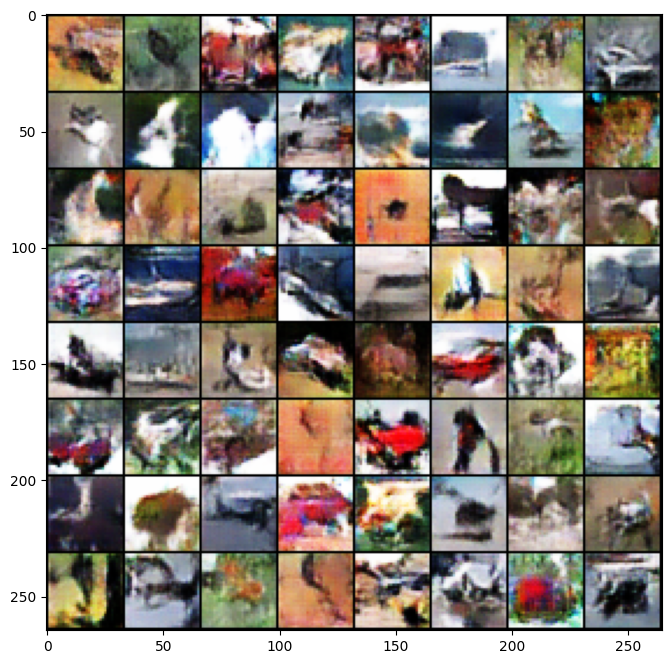

In [ ]:
set_seed(241)

dcgan = DCGAN()
dcgan.load_state_dict(torch.load("dcgan.pt", map_location=device))

actmax_results = dcgan.actmax(np.random.normal(size=(64, dcgan.code_size)))
fig = plt.figure(figsize = (8, 8))   
ax1 = plt.subplot(111)
ax1.imshow(make_grid(actmax_results, padding=1, normalize=True).numpy().transpose((1, 2, 0)))
plt.show()

The output should have less variety than those generated from random code, but look realisitic.

A similar technique can be used to reconstruct a test sample, that is, to find the code that most closely approximates the test sample. To achieve this, we only need to change the loss function from discriminator's loss to the squared L2-distance between the generated image and the target image:

$$\min_{z} \left|\left|G_{\phi}(z)-x\right|\right|_2^2$$

This time, we always start from a zero vector.


## **For this part, you need to complete code blocks marked with "Prob 2-4" above.** Then run the following block.

**You need to achieve a reconstruction loss < 0.145. Do NOT modify anything outside of the blocks marked for you to fill in.**

average reconstruction loss = 0.0594


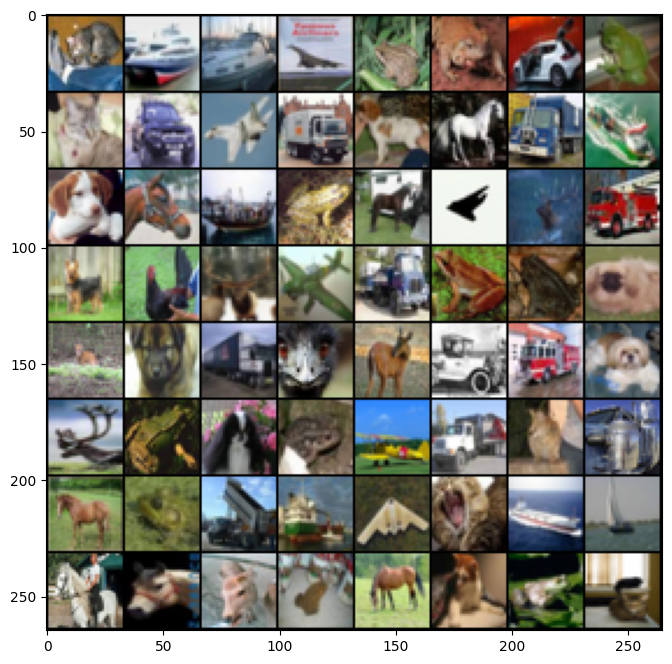

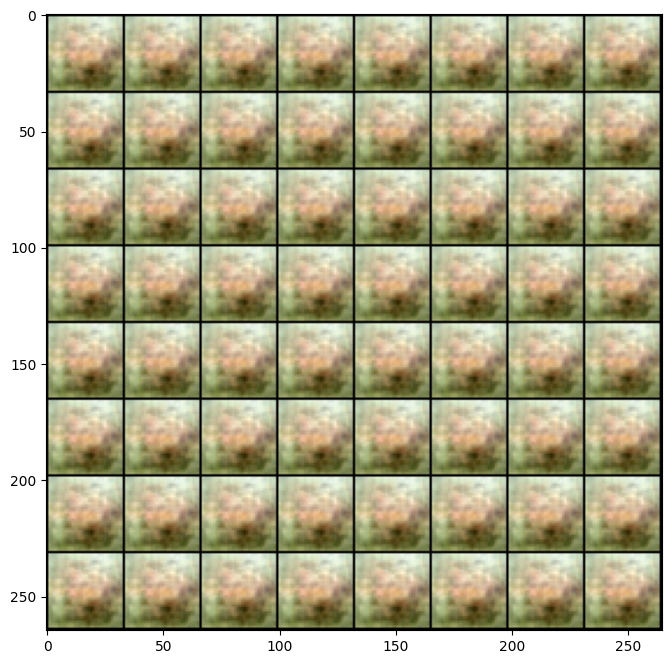

In [ ]:
dcgan = DCGAN()
dcgan.load_state_dict(torch.load("dcgan.pt", map_location=device))

avg_loss, reconstructions = dcgan.reconstruct(test_samples[0:64])
print('average reconstruction loss = {0:.4f}'.format(avg_loss))
fig = plt.figure(figsize = (8, 8))   
ax1 = plt.subplot(111)
ax1.imshow(make_grid(torch.from_numpy(test_samples[0:64]), padding=1).numpy().transpose((1, 2, 0)))
plt.show()
fig = plt.figure(figsize = (8, 8))   
ax1 = plt.subplot(111)
ax1.imshow(make_grid(reconstructions, padding=1, normalize=True).numpy().transpose((1, 2, 0)))
plt.show()

# **Submission Instruction**

See the pinned Piazza post for detailed instruction.